## 3. 模型训练
模型的训练主要分为两个部分：
1. Lip-Sync Expert Discriminator的训练。这里提供官方的预训练模型 [weight](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/radrabha_m_research_iiit_ac_in/EQRvmiZg-HRAjvI6zqN9eTEBP74KefynCwPWVmF57l-AYA?e=ZRPHKP)
2. Wav2Lip 模型的训练。

### 3.1 预训练Lip-Sync Expert
#### 1. 网络的搭建 
上面我们已经介绍了SyncNet的基本网络结构，主要有一系列的(Conv+BatchNorm+Relu)组成，这里我们对其进行了一些改进，加入了残差结构。为了方便之后的使用，我们对(Conv+BatchNorm+Relu)以及残差模块进行了封装。

# Models Training

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ########TODO######################
        # 按下面的网络结构要求，补全代码
        # self.conv_block: Sequential结构，Conv2d+BatchNorm
        # self.act: relu激活函数
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

SyncNet的主要包含两个部分：Face_encoder和Audio_encoder。每一个部分都由多个Conv2d模块组成，通过指定卷积核的大小实现对输入的下采样和特征提取

In [2]:
class SyncNet_color(nn.Module):
    def __init__(self):
        super(SyncNet_color, self).__init__()
        
        ################TODO###################
        #根据上面提供的网络结构图，补全下面卷积网络的参数

        self.face_encoder = nn.Sequential(
            Conv2d(15, 32, kernel_size=(7, 7), stride=1, padding=3),

            Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

    def forward(self, audio_sequences, face_sequences): # audio_sequences := (B, dim, T)
        
        #########################TODO#######################
        # 正向传播
        face_embedding = self.face_encoder(face_sequences)
        audio_embedding = self.audio_encoder(audio_sequences)

        audio_embedding = audio_embedding.view(audio_embedding.size(0), -1)
        face_embedding = face_embedding.view(face_embedding.size(0), -1)

        audio_embedding = F.normalize(audio_embedding, p=2, dim=1)
        face_embedding = F.normalize(face_embedding, p=2, dim=1)


        return audio_embedding, face_embedding

In [3]:
from os.path import dirname, join, basename, isfile
from tqdm import tqdm

# from models import SyncNet_color as SyncNet
import Wav2Lip.audio as audio

import torch
from torch import nn
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils import data as data_utils
import numpy as np

from glob import glob

import os, random, cv2, argparse
# from Wav2Lip.hparams import hparams, get_image_list
from Wav2Lip.hparams import hparams

## Define Dataset

In [4]:
global_step = 0 #起始的step
global_epoch = 0 #起始的epoch
device = "mps" if torch.backends.mps.is_built() else torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

syncnet_T = 5 ## 每次选取200ms的视频片段进行训练，视频的fps为25，所以200ms对应的帧数为：25*0.2=5帧
syncnet_mel_step_size = 16 # 200ms对应的声音的mel-spectrogram特征的长度为16.
data_root="../Data_Collection/lrs2_preprocessed/" #数据集的位置

Using mps device


In [5]:
def get_image_list(data_root, split):
	filelist = []

	with open('../Data_Collection/lrs2_preprocessed/filelists/{}.txt'.format(split)) as f:
		for line in f:
			line = line.strip()
			if ' ' in line: line = line.split()[0]
			filelist.append(os.path.join(data_root, line))

	return filelist

In [6]:
class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def crop_audio_window(self, spec, start_frame):
        # num_frames = (T x hop_size * fps) / sample_rate
        start_frame_num = self.get_frame_id(start_frame)
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))

        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]


    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        return: x,mel,y
        x: 五张嘴唇图片
        mel: 对应的语音的mel spectrogram
        t: 同步or不同步
        
        """
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1)
            vidname = self.all_videos[idx]

            img_names = list(glob(join(vidname, '*.jpg')))
            # print(len(img_names))
            if len(img_names) <= 3 * syncnet_T:
                continue
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)
            
            
            #随机决定是产生负样本还是正样本
            if random.choice([True, False]):
                y = torch.ones(1).float()
                chosen = img_name
            else:
                y = torch.zeros(1).float()
                chosen = wrong_img_name

            window_fnames = self.get_window(chosen)
            if window_fnames is None:
                continue

            window = []
            all_read = True
            for fname in window_fnames:
                img = cv2.imread(fname)
                if img is None:
                    all_read = False
                    break
                try:
                    img = cv2.resize(img, (hparams.img_size, hparams.img_size))
                except Exception as e:
                    all_read = False
                    break

                window.append(img)

            if not all_read: continue

            try:
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)

                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue

            mel = self.crop_audio_window(orig_mel.copy(), img_name)

            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            # H x W x 3 * T
            x = np.concatenate(window, axis=2) / 255.
            x = x.transpose(2, 0, 1)
            x = x[:, x.shape[1]//2:]

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)

            return x, mel, y

# Read all data

### Need update audio.py line 100 for latest librosa

In [12]:
ds=Dataset("train")
x,mel,t=ds[0]
print(x.shape)
print(mel.shape)
print(t.shape)


torch.Size([15, 48, 96])
torch.Size([1, 80, 16])
torch.Size([1])


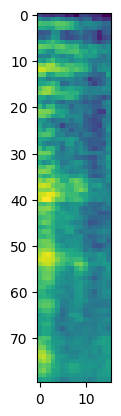

In [13]:
import matplotlib.pyplot as plt
plt.imshow(mel[0].numpy())

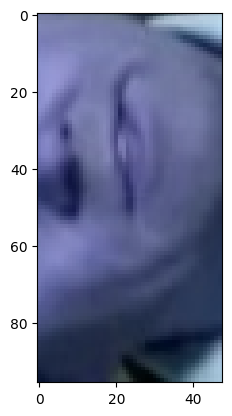

In [14]:
plt.imshow(x[:3,:,:].transpose(0,2).numpy())